<div>
    <img src="../images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Introduction to Deep Learning </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[DSAIS]</a> MSc in Data Science & Artificial Intelligence Strategy <br/>
         Paris | © Saeed VARASTEH
    </span>
</div>

## Lecture 04 : Model Training: Binary Classification

In this notebook, we're going to work through a binary classification problem with PyTorch.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

np.random.seed(72)
torch.manual_seed(72)
device = 'cpu'

---

### Data

Let's begin by making some data.

We'll use the `make_circles()` method from Scikit-Learn to generate two circles with different coloured dots.

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)
X.shape, y.shape

((1000, 2), (1000,))

In [3]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

This tells us that our problem is __binary classification__ since there's only two labels __(0 or 1)__ in y.

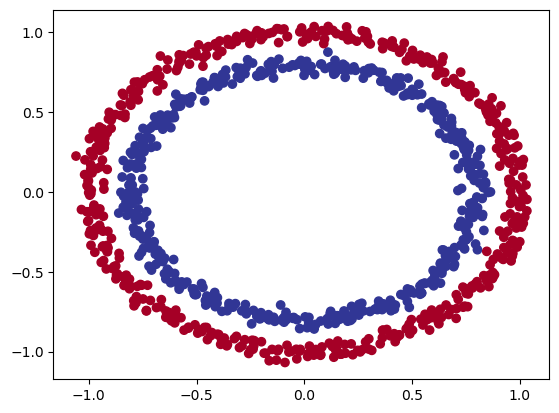

In [4]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

### Create Train/Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

Nice! Looks like we've now got 800 training samples and 200 testing samples.

### Dataset

In [6]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).float()
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return len(self.data)
    
train_dataset = MyDataset(X_train, y_train)

### Train/Validation Split

In [7]:
train_dataset, val_dataset = random_split(train_dataset, [600, 200])

len(train_dataset), len(val_dataset) # after train/val split

(600, 200)

### DataLoaders

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)

### Building a Model

One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations with result in errors in your models.

We have two input features and one output.

How about we create a simple linear model?

We'll want a model capable of handling our __X__ data as inputs and producing a label __$\hat{y}$__ as ouput.

In other words, given __X__ (features) we want our model to predict __$\hat{y}$__ (label).

In [9]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1) # takes in 2 features, produces 1 output feature
    
    def forward(self, x):
        return self.linear(x)

### Loss Function

We've setup a loss (`nn.MSELoss`) before in previous notebook.

But different problem types require different loss function.

If you remember from the lecture, for a binary classification problem (like ours), you'll often use __binary cross entropy__ as the loss function.

For that, you have two options: `torch.nn.BCELossWithLogits` or `torch.nn.BCELoss`.

- `torch.nn.BCELoss()`: - Creates a loss function that measures the binary cross entropy between the target (label) and input probabilites.
- `torch.nn.BCEWithLogitsLoss()`: - This is the same as above except it has a sigmoid layer (`nn.Sigmoid)` built-in (we'll see what this means soon).


In [10]:
loss_fn = nn.BCEWithLogitsLoss()

<div class="alert-info">
    The raw outputs (unmodified) of our model are often referred to as <b>logits</b>. That's what our model is outputing above when it takes in the input data.
</div>

However, these numbers are hard to interpret. We'd like some numbers that are comparable to our truth labels.

<div class="alert-info">
To get our model's raw outputs (logits) into such a form, we can use the <b>sigmoid activation function</b>. Sigmoid function will map the raw logits to <b>prediction probabilities</b> (i.e. values between <b>0.</b> and <b>1.</b>).
</div>

<div class="alert-success">
<b>In other words, the values are now how much the model thinks the data point belongs to one class or another.</b>
</div>

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class. 

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the `nn.BCEWithLogitsLoss` (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

### Optimizer

Unlike the loss function, which is specific to each problem, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, so can too the Adam optimizer (`torch.optim.Adam()`).

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate __0.1__.

### Evaluation Metric

Now let's also create an evaluation metric.

An evaluation metric can be used to offer another perspective on how your model is going.

__If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.__

There are several evaluation metrics that can be used for classification problems but let's start out with __accuracy__.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

Let's write a function to do so.

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

Excellent! We can now use this function whilst training our model to measure it's performance alongside the loss.

### Model Training

In [12]:
model = CircleModel().to(device)

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 1e-1
n_epochs = 100

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch).squeeze() # squeeze to remove extra `1` dimensions,
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val).squeeze()
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.round(torch.sigmoid(y_logits)) 
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")


Epoch: 0 | Loss: 0.74884, Accuracy: 46.93% | val loss: 0.71628, val acc: 44.64%
Epoch: 10 | Loss: 0.69323, Accuracy: 54.50% | val loss: 0.69504, val acc: 50.00%
Epoch: 20 | Loss: 0.69300, Accuracy: 55.32% | val loss: 0.69614, val acc: 49.11%
Epoch: 30 | Loss: 0.69300, Accuracy: 54.17% | val loss: 0.69632, val acc: 50.00%
Epoch: 40 | Loss: 0.69301, Accuracy: 54.17% | val loss: 0.69634, val acc: 50.00%
Epoch: 50 | Loss: 0.69301, Accuracy: 54.17% | val loss: 0.69634, val acc: 50.00%
Epoch: 60 | Loss: 0.69301, Accuracy: 54.17% | val loss: 0.69634, val acc: 50.00%
Epoch: 70 | Loss: 0.69301, Accuracy: 54.17% | val loss: 0.69634, val acc: 50.00%
Epoch: 80 | Loss: 0.69301, Accuracy: 54.17% | val loss: 0.69634, val acc: 50.00%
Epoch: 90 | Loss: 0.69301, Accuracy: 54.17% | val loss: 0.69634, val acc: 50.00%


Learning curves:

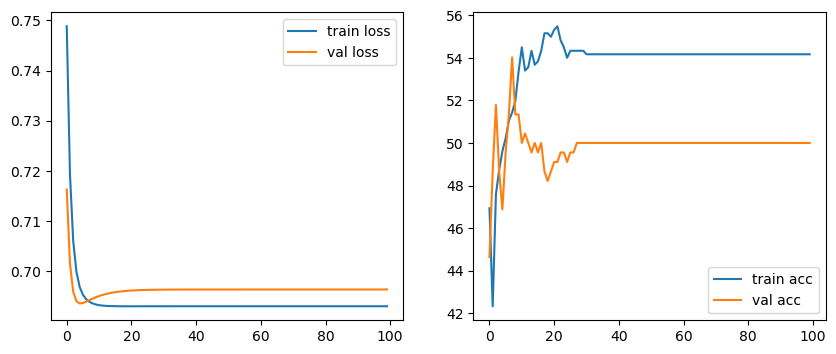

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

Hmm, what do you notice about the performance of our model?

The accuracy barely moves above 50%.

How could we investigate this further? Let's make a plot of our model's predictions

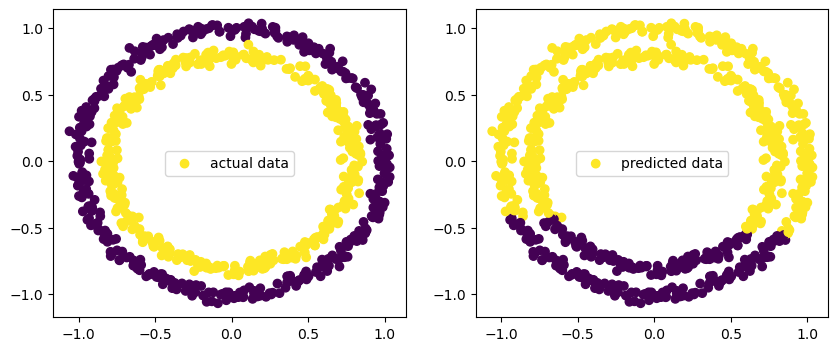

In [14]:
y_pred = model( torch.from_numpy(X_train).float().to(device) )
y_pred = torch.round(torch.sigmoid(y_pred)).detach().numpy()

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, label="actual data");
ax[0].legend();

ax[1].scatter(X_train[:,0], X_train[:,1], c=y_pred, label="predicted data");
ax[1].legend();

plt.legend()

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line!

In machine learning terms, our model is __underfitting__, meaning it's not learning predictive patterns from the data.

How could we improve this?

### Improving the Model

Let's try to fix our model's underfitting problem.

Focusing __specifically on the model__ (not the data), there are a few ways we could do this.


| Model improvement technique* | What does it do? |
| :----- | :----- |
| **Add more layers** | Each layer *potentially* increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network *deeper*. |
| **Add more hidden units** | Similar to the above, more hidden units per layer means a *potential* increase in learning capabilities of the model, more hidden units is often referred to as making your neural network *wider*. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this. |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough. |
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem. |

<div class="alert-success">
Note: because you can adjust all of these by hand, they're referred to as hyperparameters*.
</div>

#### Attempt 01

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=200 instead of epochs=100).

In [15]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(5, 1) # takes in 5 features, produces 1 feature (y)
    
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        # Computation goes through layer_1 first then the output of layer_1 goes through layer_2
        out = self.layer_1(x)
        out = self.layer_2(out) 
        return out 

You can also do the same as above using `nn.Sequential`.

In [16]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 1)
            )
        
    def forward(self, x):
        out = self.fc(x)
        return out 

Why not just always use `nn.Sequential`?

__`nn.Sequential` is fantastic for straight-forward computations__, however, as the namespace says, it always runs in sequential order. More on this later.

#### Try it out!

In [17]:
model = CircleModel().to(device)

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 1e-1
n_epochs = 200

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch).squeeze() # squeeze to remove extra `1` dimensions,
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val).squeeze()
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.round(torch.sigmoid(y_logits)) 
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")


Epoch: 0 | Loss: 0.69830, Accuracy: 50.99% | val loss: 0.69817, val acc: 50.89%
Epoch: 10 | Loss: 0.69362, Accuracy: 53.51% | val loss: 0.69619, val acc: 50.45%
Epoch: 20 | Loss: 0.69351, Accuracy: 55.26% | val loss: 0.69635, val acc: 48.21%
Epoch: 30 | Loss: 0.69349, Accuracy: 55.15% | val loss: 0.69638, val acc: 47.32%
Epoch: 40 | Loss: 0.69348, Accuracy: 54.82% | val loss: 0.69638, val acc: 47.32%
Epoch: 50 | Loss: 0.69347, Accuracy: 54.82% | val loss: 0.69638, val acc: 47.32%
Epoch: 60 | Loss: 0.69347, Accuracy: 54.82% | val loss: 0.69638, val acc: 47.32%
Epoch: 70 | Loss: 0.69346, Accuracy: 54.66% | val loss: 0.69638, val acc: 47.32%
Epoch: 80 | Loss: 0.69345, Accuracy: 54.66% | val loss: 0.69638, val acc: 47.32%
Epoch: 90 | Loss: 0.69344, Accuracy: 54.50% | val loss: 0.69637, val acc: 47.32%
Epoch: 100 | Loss: 0.69343, Accuracy: 54.50% | val loss: 0.69637, val acc: 47.32%
Epoch: 110 | Loss: 0.69342, Accuracy: 54.50% | val loss: 0.69637, val acc: 47.32%
Epoch: 120 | Loss: 0.69341,

What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

Let's visualize model predictions.

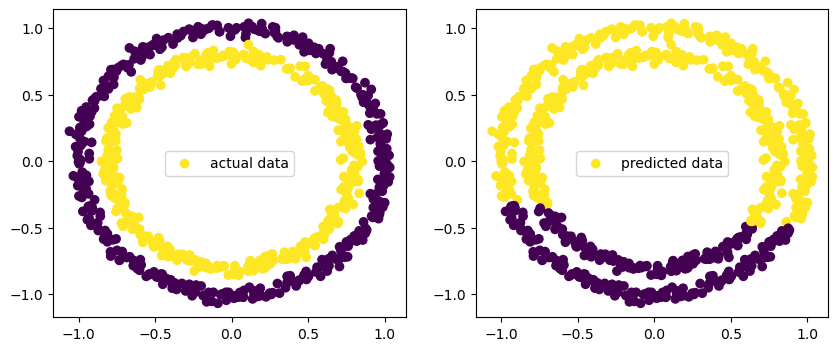

In [18]:
y_pred = model( torch.from_numpy(X_train).float().to(device) )
y_pred = torch.round(torch.sigmoid(y_pred)).detach().numpy()

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, label="actual data");
ax[0].legend();

ax[1].scatter(X_train[:,0], X_train[:,1], c=y_pred, label="predicted data");
ax[1].legend();

plt.legend()

Hmmm. Same issue!

Our model is still drawing a straight line!

<div class="alert-warning">
    <b>Note</b>: The missing piece: non-linearity!
</div>

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

Let's find out.

#### Attempt 02

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with has a non-linear form.

What do you think will happen when we introduce the capability for our model to use __non-linear actviation functions__?

One of the most common and best performing is [ReLU] (rectified linear-unit, `torch.nn.ReLU()`).

Rather than talk about it, let's put it in our neural network between the hidden layers in the forward pass and see what happens.

#### Training a model with non-linearity

In [19]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(), # <- add in ReLU activation function
            nn.Linear(5, 1)
            )
        
    def forward(self, x):
        out = self.fc(x)
        return out 

In [20]:
model = CircleModel().to(device)

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 1e-1
n_epochs = 200

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch).squeeze() # squeeze to remove extra `1` dimensions,
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val).squeeze()
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.round(torch.sigmoid(y_logits)) 
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")


Epoch: 0 | Loss: 0.69436, Accuracy: 51.26% | val loss: 0.69740, val acc: 49.11%
Epoch: 10 | Loss: 0.69103, Accuracy: 51.86% | val loss: 0.69498, val acc: 50.00%
Epoch: 20 | Loss: 0.68924, Accuracy: 52.80% | val loss: 0.69400, val acc: 49.11%
Epoch: 30 | Loss: 0.68699, Accuracy: 54.22% | val loss: 0.69253, val acc: 50.45%
Epoch: 40 | Loss: 0.68420, Accuracy: 53.18% | val loss: 0.69055, val acc: 50.45%
Epoch: 50 | Loss: 0.67975, Accuracy: 53.67% | val loss: 0.68714, val acc: 51.34%
Epoch: 60 | Loss: 0.67369, Accuracy: 59.76% | val loss: 0.68197, val acc: 56.25%
Epoch: 70 | Loss: 0.66552, Accuracy: 65.24% | val loss: 0.67386, val acc: 63.84%
Epoch: 80 | Loss: 0.65252, Accuracy: 70.01% | val loss: 0.65995, val acc: 64.73%
Epoch: 90 | Loss: 0.63338, Accuracy: 76.75% | val loss: 0.63738, val acc: 72.32%
Epoch: 100 | Loss: 0.60795, Accuracy: 81.96% | val loss: 0.60765, val acc: 82.59%
Epoch: 110 | Loss: 0.57798, Accuracy: 92.54% | val loss: 0.57479, val acc: 91.96%
Epoch: 120 | Loss: 0.54405,

Learning curves:

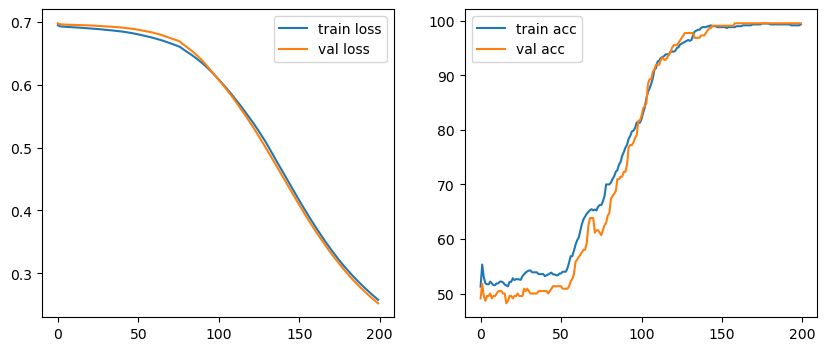

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

### Making Predications

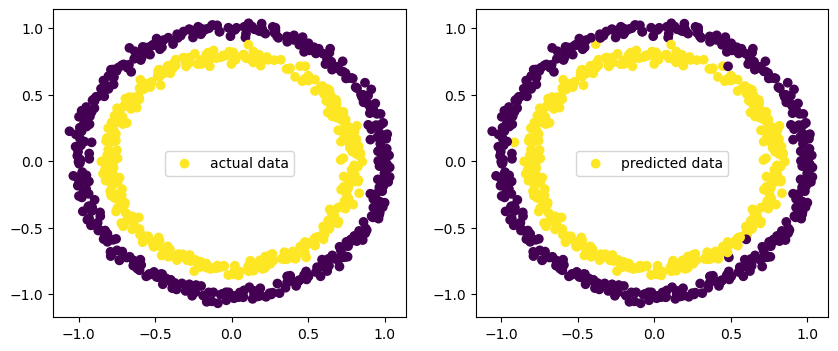

In [22]:
y_pred = model( torch.from_numpy(X_train).float().to(device) )
y_pred = torch.round(torch.sigmoid(y_pred)).detach().numpy()

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, label="actual data");
ax[0].legend();

ax[1].scatter(X_train[:,0], X_train[:,1], c=y_pred, label="predicted data");
ax[1].legend();

plt.legend()

Voila! we did it ;)

---